In [1]:
import numpy as np
from tqdm import tqdm
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt
import pdb

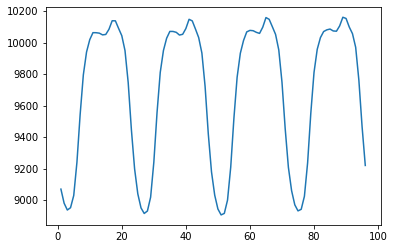

In [2]:
df = pd.read_csv('AESO_2020_demand_price.csv')
HE = []
end_index = df.shape[0]//(48 * 2) + 1
for day in range(1, end_index):
    for hour in range(1, (2 * 48) + 1):
        HE.append(hour)
df['HE'] = HE
df = df.drop(df.columns[[0, 2]], axis = 1)
df = df.set_index('HE', drop = True)
df = df.groupby('HE', as_index=True).mean()
df_to_plot = df.drop(df.columns[[0]], axis = 1)
plt.plot(df_to_plot);

In [3]:
alberta_avg_power_price = np.array(df.iloc[7:48+7, 0])
alberta_avg_demand = np.array(df.iloc[7:48+7, 1])

(48,)


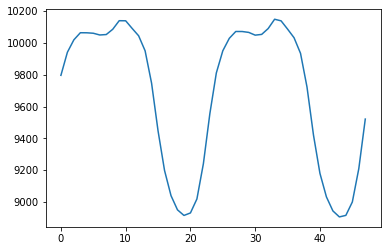

In [4]:
print(alberta_avg_demand.shape)
plt.plot(alberta_avg_demand);

In [5]:
# https://open.alberta.ca/dataset/d6205817-b04b-4360-8bb0-79eaaecb9df9/
# resource/4a06c219-03d1-4027-9c1f-a383629ab3bc/download/trans-motorized-
# vehicle-registrations-select-municipalities-2020.pdf
total_cars_in_alberta = 100
ev_market_penetration = 0.1
# SOC params
min_soc_by_8_am = 0.5
max_soc_allowed = 1
min_soc_allowed = 0.1
# Charging and discharging
charging_soc_addition_per_time_unit_per_ev = 0.15
discharging_soc_reduction_per_time_unit_per_ev = -0.15
# Power to the grid units in MWs
charging_soc_mw_addition_to_demand_per_time_unit_per_ev = 0.01
discharging_soc_mw_reduction_from_demand_per_time_unit_per_ev = 0.01
# Driving
driving_soc_reduction_per_time_unit_per_ev = 0.005
forecast_flag = False
n_percent_honesty = ['0.25', '0.5', '0.75', '1']

In [6]:
index_of_time = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,
                 15,16,17,18,19,20,21,22,23,24,25,26,
                 27,28,29,30,31,32,33,34,35,36,37,38,
                 39,40,41,42,43,44,45,46,47]
time_of_day = [8,9,10,11,12,13,14,15,16,17,18,19,20,
               21,22,23,0,1,2,3,4,5,6,7,8,9,10,11,12,
               13,14,15,16,17,18,19,20,21,22,23,0,1,2,
               3,4,5,6,7,8]

index_to_time_of_day_dict = {}
for item in range(len(index_of_time)):
    index_to_time_of_day_dict[index_of_time[item]] = time_of_day[item]
pprint(index_to_time_of_day_dict)

{0: 8,
 1: 9,
 2: 10,
 3: 11,
 4: 12,
 5: 13,
 6: 14,
 7: 15,
 8: 16,
 9: 17,
 10: 18,
 11: 19,
 12: 20,
 13: 21,
 14: 22,
 15: 23,
 16: 0,
 17: 1,
 18: 2,
 19: 3,
 20: 4,
 21: 5,
 22: 6,
 23: 7,
 24: 8,
 25: 9,
 26: 10,
 27: 11,
 28: 12,
 29: 13,
 30: 14,
 31: 15,
 32: 16,
 33: 17,
 34: 18,
 35: 19,
 36: 20,
 37: 21,
 38: 22,
 39: 23,
 40: 0,
 41: 1,
 42: 2,
 43: 3,
 44: 4,
 45: 5,
 46: 6,
 47: 7}


In [16]:
# Define experiment params
experiment_params = {'n_episodes': 300, 
                     'n_hours': 48, 
                     'n_divisions_for_soc': 10, 
                     'n_divisions_for_percent_honesty': 4,
                     'max_soc_allowed': 1,
                     'min_soc_allowed': 0.1,
                     'alpha': 0.1,
                     'epsilon': 0.1,
                     'gamma': 1,
                     'total_cars_in_alberta': 1000000,
                     'ev_market_penetration': 0.1,
                     'charging_soc_addition_per_time_unit_per_ev': 0.15, 
                     'discharging_soc_reduction_per_time_unit_per_ev': 0.15, 
                     'charging_soc_mw_addition_to_demand_per_time_unit_per_ev': 0.01, 
                     'discharging_soc_mw_reduction_from_demand_per_time_unit_per_ev': 0.01,
                     'driving_soc_reduction_per_km_per_ev': 0.005,
                     'alberta_average_demand': alberta_avg_demand,
                     'index_to_time_of_day_dict': index_to_time_of_day_dict,
                     'forecast_flag': forecast_flag,
                     'n_percent_honesty': n_percent_honesty
                    }

In [17]:
# Experiment function
class Experiment():
    
    def __init__(self, experiment_params={}):
        
        # Initialize all experiment params
        self.n_episodes = experiment_params.get('n_episodes')
        self.n_hours = experiment_params.get('n_hours')
        self.n_divisions_for_soc = experiment_params.get('n_divisions_for_soc')
        self.n_divisions_for_percent_honesty = experiment_params.get('n_divisions_for_percent_honesty')
        self.max_soc_allowed = experiment_params.get('max_soc_allowed')
        self.min_soc_allowed = experiment_params.get('in_soc_allowed')
        self.alpha = experiment_params.get('alpha')
        self.epsilon = experiment_params.get('epsilon')
        self.gamma = experiment_params.get('gamma')
        self.total_cars_in_alberta = experiment_params.get('total_cars_in_alberta')
        self.ev_market_penetration = experiment_params.get('ev_market_penetration')
        self.charging_soc_addition_per_time_unit_per_ev = experiment_params.get('charging_soc_addition_'\
                                                                           'per_time_unit_per_ev')
        self.discharging_soc_reduction_per_time_unit_per_ev = experiment_params.get('discharging_'\
                                                                               'soc_reduction_per_time_unit_per_ev')
        self.charging_soc_mw_addition_to_demand_per_time_unit_per_ev = experiment_params.get('charging_'\
                                                                                        'soc_mw_addition_to_demand_'\
                                                                                        'per_time_unit_per_ev') 
        self.discharging_soc_mw_reduction_from_demand_per_time_unit_per_ev = experiment_params.get('discharging_'\
                                                                                              'soc_mw_reduction_'\
                                                                                              'from_demand_per_'
                                                                                              'time_unit_per_ev')
        self.driving_soc_reduction_per_km_per_ev = experiment_params.get('driving_soc_reduction_per_km_per_ev')
        self.alberta_average_demand = experiment_params.get('alberta_average_demand')
        self.index_to_time_of_day_dict = experiment_params.get('index_to_time_of_day_dict')
        self.forecast_flag = experiment_params.get('forecast_flag')
        self.n_percent_honesty = experiment_params.get('n_percent_honesty')
            
        # Initialize q-value table    
        self.Q = self.initialize_action_value()
        
        # Display params
        print('Experiment parameters are: ')
        print(*experiment_params.items(), sep='\n')
            
    def start_experiment(self):
        """Initialize the experiment"""
        
        # Calculate the number of EVs in the province
        self.num_of_evs = self.total_cars_in_alberta * self.ev_market_penetration
             
        # Initialize an array of SOCs for each EV
        self.soc_of_evs = [0.5] * int(self.num_of_evs)
        
#         # Initialize the charge status of each EV
#         self.charge_status_of_evs = []
        
#         # Initialize the array of driving distance for each EV
#         self.driving_distance_of_evs = []
        
        # Initialize the last total load and average
        self.last_total_load = 0
        self.last_average = 1
        self.last_percent_honest = np.random.choice(self.n_percent_honesty)

    def run(self):
        """Main method to run the experiment with initialized params"""
        
        # Monitor the trace as the program runs
        #pdb.set_trace()
        
        self.reward_list = []
        self.average_list = []
        # Repeat for every episode
        for episode in tqdm(range(self.n_episodes), ncols=100):
            
            print('-----------------------Starting Episode----------------------------------------------')
            
            # Initialize the experiment
            self.start_experiment()
            
            # Calculate the percent honesty of people 
            percent_honest = self.last_percent_honest #comes out as string
            
            # Repeat for every hour in the number of hours
            for hour in range(0, self.n_hours):
                
                # Calculate the percent honesty for the next hour
                if forecast_flag:
                    next_percent_honest = np.random.choice(self.n_percent_honesty, p = [0.25, 0.25, 0.25, 0.25])
                else:
                    next_percent_honest = np.random.choice(self.n_percent_honesty)
                    
                # Get the SOC division for each EV
                soc_div_index = self.get_division_index()
                
                # Get the indicator which shows whether each EV is
                # keeping to its original intention and make sure 
                # its applied randomly to each EV via shuffling
                status_evs = ([1] * int(self.num_of_evs * (1 - float(percent_honest))) 
                              + [0] * int(self.num_of_evs * float(percent_honest)))
                np.random.shuffle(status_evs)
                
                # Dictionary keeping track of what actions
                # were taken for each SOC division
                div_to_action_dict = {}
                
                # Loop for every SOC division
                for division in range(0, self.n_divisions_for_soc):
                    
                    # Extract the q-value for the division, hour, 
                    # and percent of EVs st
                    Q = self.Q[division][hour][int(float(percent_honest)/0.25 - 1)]
                    # Choose an action using a policy 
                    # (ex: epsilon-greedy)
                    action = self.choose_action(Q)
                    # Calculate the load for each SOC division 
                    #percent_honest = float(percent_honest) 
                    #next_percent_honest = float(next_percent_honest)
                    
                    if self.index_to_time_of_day_dict[hour] in [8,9,10,11,12,13,14,15]:
            
                        driving_distance_of_evs = abs(np.random.normal(10, 5, int(self.num_of_evs)))
                        soc_reduction_for_evs = self.driving_soc_reduction_per_km_per_ev * driving_distance_of_evs
                        for ii, soc in enumerate(self.soc_of_evs):
                            if soc_div_index[ii] == division:
                                self.soc_of_evs[ii] = soc - soc_reduction_for_evs[ii]
                        e_evs = 0
            
                    elif self.index_to_time_of_day_dict[hour] in [16,17,18,19,20,21,22,23,0,1,2]:

                        charging_load = 0
                        discharging_load = 0
                        driving_distance_of_evs = np.random.normal(5, 5, int(self.num_of_evs))

                        if action == 0:
                            #charging for soc
                            for ii, soc in enumerate(self.soc_of_evs):
                                if soc_div_index[ii] == division:
                                    if status_evs[ii] == 1:
                                        self.soc_of_evs[ii] = min(1, soc + self.charging_soc_addition_per_time_unit_per_ev)
                                        if self.soc_of_evs[ii] == 1:
                                            charging_load += 0
                                        else:
                                            charging_load += self.charging_soc_mw_addition_to_demand_per_time_unit_per_ev
                            #discharging for driving
                            soc_reduction_for_evs = self.driving_soc_reduction_per_km_per_ev * driving_distance_of_evs
                            for ii, soc in enumerate(self.soc_of_evs):
                                if soc_div_index[ii] == division:
                                    if status_evs[ii] == 0:
                                        self.soc_of_evs[ii] = soc - soc_reduction_for_evs[ii]
                        elif action == 1:
                            #discharging for soc
                            for ii, soc in enumerate(self.soc_of_evs):
                                if soc_div_index[ii] == division:
                                    if status_evs[ii] == 1:
                                        self.soc_of_evs[ii] = max(0, soc - self.discharging_soc_reduction_per_time_unit_per_ev)
                                        if self.soc_of_evs[ii] == 0:
                                            discharging_load += 0
                                        else:
                                            discharging_load += self.charging_soc_mw_addition_to_demand_per_time_unit_per_ev
                            #discharging for driving
                            soc_reduction_for_evs = self.driving_soc_reduction_per_km_per_ev * driving_distance_of_evs
                            for ii, soc in enumerate(self.soc_of_evs):
                                if soc_div_index[ii] == division:
                                    if status_evs[ii] == 0:
                                        self.soc_of_evs[ii] = soc - soc_reduction_for_evs[ii]
                        else:
                            #do nothing
                            #discharging for driving
                            soc_reduction_for_evs = self.driving_soc_reduction_per_km_per_ev * driving_distance_of_evs
                            for ii, soc in enumerate(self.soc_of_evs):
                                if soc_div_index[ii] == division:
                                    if status_evs[ii] == 0:
                                        self.soc_of_evs[ii] = soc - soc_reduction_for_evs[ii]

                        e_evs = charging_load - discharging_load

                    elif self.index_to_time_of_day_dict[hour] in [3,4,5,6,7]:

                        charging_load = 0
                        discharging_load = 0

                        if action == 0:
                            #charging for soc
                            for ii, soc in enumerate(self.soc_of_evs):
                                if soc_div_index[ii] == division:
                                    if status_evs[ii] == 1:
                                        self.soc_of_evs[ii] = min(1, soc + self.charging_soc_addition_per_time_unit_per_ev)
                                        if self.soc_of_evs[ii] == 1:
                                            charging_load += 0
                                        else:
                                            charging_load += self.charging_soc_mw_addition_to_demand_per_time_unit_per_ev
                        elif action == 1:
                            #discharging for soc
                            for ii, soc in enumerate(self.soc_of_evs):
                                if soc_div_index[ii] == division:
                                    if status_evs[ii] == 1:
                                        self.soc_of_evs[ii] = max(0, soc - self.discharging_soc_reduction_per_time_unit_per_ev)
                                        if self.soc_of_evs[ii] == 0:
                                            discharging_load += 0
                                        else:
                                            discharging_load += self.charging_soc_mw_addition_to_demand_per_time_unit_per_ev
                        else:
                            #do nothing
                            pass

                        if action == 0 or action == 1:
                            e_evs = charging_load - discharging_load
                        else:
                            e_evs = 0
                    
                    #print(f'Divsion {division}, hour {hour}, load = {load_from_division}')
                    # Populate division-to-action dictionary
                    # to preserve the action that was picked
                    # for each SOC division
                    div_to_action_dict[division] = (action, e_evs)
                
                # Get next hour based on current hour
                next_hour = self.get_next_hour(hour)
                
                # Calculate the total load based on
                # the loads from each SOC division
                total_load = 0
                for div in div_to_action_dict.keys():
                    total_load += div_to_action_dict[div][1]
                
                # Calculate the total power demand by adding the
                # power demand with the additional demand from EVs
                total_load += self.alberta_average_demand[self.index_to_time_of_day_dict[hour]]
                
                # Calculate the Peak-to-Average ratio and the reward
                # The reward 
                average = ((hour + 1 - 1) * self.last_average + total_load) / (hour + 1)
                reward = -max(total_load, self.last_total_load) / average
                
                # Update the qction-value function for each
                # SOC division, hour, and percent honesty
                for division in range(0, self.n_divisions_for_soc):

                    if next_hour <= 47:
                        delta = (reward 
                                 + self.gamma * np.max(self.Q[division][next_hour][int(float(next_percent_honest)//0.25-1)])
                                 - self.Q[division][hour][int(float(percent_honest)//0.25-1)][div_to_action_dict[division][0]])
                        self.Q[division][hour][int(float(percent_honest)//0.25-1)][div_to_action_dict[division][0]] += self.alpha * delta
                    else:
                        delta = reward - self.Q[division][hour][int(float(percent_honest)//0.25-1)][div_to_action_dict[division][0]]
                        self.Q[division][hour][int(float(percent_honest)/0.25-1)][div_to_action_dict[division][0]] += self.alpha * delta
                
                # Store the total load and peak-to-average
                # ratio
                self.last_total_load = total_load
                self.last_average = average
                self.last_percent_honest = next_percent_honest
            print('Last total load: ', self.last_total_load)
            print('Last average: ', self.last_average)
            print('Reward: ', reward)
            self.reward_list.append(reward)
            self.average_list.append(average)
        
        print(self.Q)

    # Initialize action-values array
    def initialize_action_value(self):

#         dict_for_percent_honesty = {}
#         for item in self.n_percent_honesty:
#             dict_for_percent_honesty[item] = [0, 0, 0]
#         Q = self.n_divisions_for_soc * self.n_hours * [dict_for_percent_honesty]
#         Q = np.array(Q).reshape((self.n_divisions_for_soc, self.n_hours))
        Q = np.zeros(shape = (10, 48, 4, 3))

        return Q

    # Choose action using epsilon-greedy    
    def choose_action(self, Q):
        if np.random.random() < self.epsilon:
            action = np.random.choice([0, 1, 2])
        else:
            action = self.argmax(Q)
            
        return action
    
    def argmax(self, q_values):
        """argmax with random tie-breaking
        Args:
            q_values (Numpy array): the array of action values
        Returns:
            action (int): an action with the highest value
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return np.random.choice(ties)

    # Get the load for each SOC division
    def get_load_from_action_for_div(self, 
                                     hour, 
                                     percent_honest, 
                                     action, 
                                     division, 
                                     soc_div_index, 
                                     status_evs, 
                                     next_percent_honest):
            
        if self.index_to_time_of_day_dict[hour] in [8,9,10,11,12,13,14,15]:
            
            driving_distance_of_evs = abs(np.random.normal(10, 5, int(self.num_of_evs)))
            soc_reduction_for_evs = self.driving_soc_reduction_per_km_per_ev * driving_distance_of_evs
            for ii, soc in enumerate(self.soc_of_evs):
                if soc_div_index[ii] == division:
                    self.soc_of_evs[ii] = soc - soc_reduction_for_evs[ii]
            e_evs = 0
            
        elif self.index_to_time_of_day_dict[hour] in [16,17,18,19,20,21,22,23,0,1,2]:
            
            charging_load = 0
            discharging_load = 0
            driving_distance_of_evs = np.random.normal(5, 5, int(self.num_of_evs))
            
            if action == 0:
                #charging for soc
                for ii, soc in enumerate(self.soc_of_evs):
                    if soc_div_index[ii] == division:
                        if status_evs[ii] == 1:
                            self.soc_of_evs[ii] = min(1, soc + self.charging_soc_addition_per_time_unit_per_ev)
                            if self.soc_of_evs[ii] == 1:
                                charging_load += 0
                            else:
                                charging_load += self.charging_soc_mw_addition_to_demand_per_time_unit_per_ev
                #discharging for driving
                soc_reduction_for_evs = self.driving_soc_reduction_per_km_per_ev * driving_distance_of_evs
                for ii, soc in enumerate(self.soc_of_evs):
                    if soc_div_index[ii] == division:
                        if status_evs[ii] == 0:
                            self.soc_of_evs[ii] = soc - soc_reduction_for_evs[ii]
            elif action == 1:
                #discharging for soc
                for ii, soc in enumerate(self.soc_of_evs):
                    if soc_div_index[ii] == division:
                        if status_evs[ii] == 1:
                            self.soc_of_evs[ii] = max(0, soc - self.discharging_soc_reduction_per_time_unit_per_ev)
                            if self.soc_of_evs[ii] == 0:
                                discharging_load += 0
                            else:
                                discharging_load += self.charging_soc_mw_addition_to_demand_per_time_unit_per_ev
                #discharging for driving
                soc_reduction_for_evs = self.driving_soc_reduction_per_km_per_ev * driving_distance_of_evs
                for ii, soc in enumerate(self.soc_of_evs):
                    if soc_div_index[ii] == division:
                        if status_evs[ii] == 0:
                            self.soc_of_evs[ii] = soc - soc_reduction_for_evs[ii]
            else:
                #do nothing
                #discharging for driving
                soc_reduction_for_evs = self.driving_soc_reduction_per_km_per_ev * driving_distance_of_evs
                for ii, soc in enumerate(self.soc_of_evs):
                    if soc_div_index[ii] == division:
                        if status_evs[ii] == 0:
                            self.soc_of_evs[ii] = soc - soc_reduction_for_evs[ii]
                
            e_evs = charging_load - discharging_load
            
        elif self.index_to_time_of_day_dict[hour] in [3,4,5,6,7]:
            
            charging_load = 0
            discharging_load = 0
            
            if action == 0:
                #charging for soc
                for ii, soc in enumerate(self.soc_of_evs):
                    if soc_div_index[ii] == division:
                        if status_evs[ii] == 1:
                            self.soc_of_evs[ii] = min(1, soc + self.charging_soc_addition_per_time_unit_per_ev)
                            if self.soc_of_evs[ii] == 1:
                                charging_load += 0
                            else:
                                charging_load += self.charging_soc_mw_addition_to_demand_per_time_unit_per_ev
            elif action == 1:
                #discharging for soc
                for ii, soc in enumerate(self.soc_of_evs):
                    if soc_div_index[ii] == division:
                        if status_evs[ii] == 1:
                            self.soc_of_evs[ii] = max(0, soc - self.discharging_soc_reduction_per_time_unit_per_ev)
                            if self.soc_of_evs[ii] == 0:
                                discharging_load += 0
                            else:
                                discharging_load += self.charging_soc_mw_addition_to_demand_per_time_unit_per_ev
            else:
                #do nothing
                pass
                
            if action == 0 or action == 1:
                e_evs = charging_load - discharging_load
            else:
                e_evs = 0
        
        return e_evs
    
    # Get the next hour based on
    # the current hour
    def get_next_hour(self, hour):

        if hour < 47:
            next_hour = hour + 1
        else:
            next_hour = 0
            
        return next_hour
    
    # Get the list of the SOC
    # division for each EV
    def get_division_index(self):
        
        soc_index = []
        for item in self.soc_of_evs:
            index = self.switch_index(item)
            soc_index.append(index)
            
        return soc_index
    
    # Get the SOC division
    # based on the SOC
    def switch_index(self, soc):
        
        if 0 < soc <= 0.1:
            index = 0
        elif soc <= 0.2:
            index = 1
        elif soc <= 0.3:
            index = 2
        elif soc <= 0.4:
            index = 3
        elif soc <= 0.5:
            index = 4
        elif soc <= 0.6:
            index = 5
        elif soc <= 0.7:
            index = 6
        elif soc <= 0.8:
            index = 7
        elif soc <= 0.9:
            index = 8
        elif soc <= 1:
            index = 9
        else:
            index = 'discharged'
            
        return index
    
    # Show the calculated policy
    def render_policy(self):
        pass

In [18]:
# Run experiment
experiment = Experiment(experiment_params)
experiment.run()

  0%|                                                                       | 0/300 [00:00<?, ?it/s]

Experiment parameters are: 
('n_episodes', 300)
('n_hours', 48)
('n_divisions_for_soc', 10)
('n_divisions_for_percent_honesty', 4)
('max_soc_allowed', 1)
('min_soc_allowed', 0.1)
('alpha', 0.1)
('epsilon', 0.1)
('gamma', 1)
('total_cars_in_alberta', 1000000)
('ev_market_penetration', 0.1)
('charging_soc_addition_per_time_unit_per_ev', 0.15)
('discharging_soc_reduction_per_time_unit_per_ev', 0.15)
('charging_soc_mw_addition_to_demand_per_time_unit_per_ev', 0.01)
('discharging_soc_mw_reduction_from_demand_per_time_unit_per_ev', 0.01)
('driving_soc_reduction_per_km_per_ev', 0.005)
('alberta_average_demand', array([ 9796.02197802,  9940.9010989 , 10019.        , 10063.54945055,
       10063.20879121, 10060.35164835, 10049.46153846, 10052.23076923,
       10085.14285714, 10139.13186813, 10138.62637363, 10090.64835165,
       10044.3956044 ,  9950.0989011 ,  9746.67032967,  9446.98901099,
        9198.65934066,  9040.31868132,  8951.08791209,  8915.9010989 ,
        8931.57142857,  9019.4725

  0%|▏                                                              | 1/300 [00:11<59:16, 11.90s/it]

Last total load:  10164.690769230769
Last average:  9783.606540750878
Reward:  -1.0700963386920714
-----------------------Starting Episode----------------------------------------------


  1%|▍                                                              | 2/300 [00:23<58:32, 11.79s/it]

Last total load:  10341.710769230589
Last average:  9774.679665750878
Reward:  -1.058010198069867
-----------------------Starting Episode----------------------------------------------


  1%|▋                                                              | 3/300 [00:35<58:24, 11.80s/it]

Last total load:  9984.510769230772
Last average:  9808.745915750846
Reward:  -1.0750509421931727
-----------------------Starting Episode----------------------------------------------


  1%|▊                                                              | 4/300 [00:47<58:45, 11.91s/it]

Last total load:  9987.360769230767
Last average:  9776.53779075088
Reward:  -1.0215641756818388
-----------------------Starting Episode----------------------------------------------


  2%|█                                                              | 5/300 [00:58<57:14, 11.64s/it]

Last total load:  10331.120769230722
Last average:  9806.424040750842
Reward:  -1.0535054089339282
-----------------------Starting Episode----------------------------------------------


  2%|█▎                                                             | 6/300 [01:08<54:40, 11.16s/it]

Last total load:  10779.950769230252
Last average:  9704.48091575091
Reward:  -1.1108219865458022
-----------------------Starting Episode----------------------------------------------


  2%|█▍                                                             | 7/300 [01:19<54:20, 11.13s/it]

Last total load:  10274.01076923072
Last average:  9741.595499084238
Reward:  -1.0566330268413526
-----------------------Starting Episode----------------------------------------------


  3%|█▋                                                             | 8/300 [01:30<54:16, 11.15s/it]

Last total load:  9941.200769230772
Last average:  9761.73674908422
Reward:  -1.0362809199306198
-----------------------Starting Episode----------------------------------------------


  3%|█▉                                                             | 9/300 [01:41<53:24, 11.01s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


  3%|██                                                            | 10/300 [01:51<52:33, 10.87s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


  4%|██▎                                                           | 11/300 [02:02<52:13, 10.84s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


  4%|██▍                                                           | 12/300 [02:13<52:19, 10.90s/it]

Last total load:  9982.180769230772
Last average:  9742.46466575089
Reward:  -1.07304485026383
-----------------------Starting Episode----------------------------------------------


  4%|██▋                                                           | 13/300 [02:25<53:36, 11.21s/it]

Last total load:  10114.700769230767
Last average:  9793.946957417525
Reward:  -1.050889042304491
-----------------------Starting Episode----------------------------------------------


  5%|██▉                                                           | 14/300 [02:36<53:28, 11.22s/it]

Last total load:  10058.780769230769
Last average:  9744.114874084238
Reward:  -1.0322929172339117
-----------------------Starting Episode----------------------------------------------


  5%|███                                                           | 15/300 [02:48<53:29, 11.26s/it]

Last total load:  10054.860769230769
Last average:  9730.30049908424
Reward:  -1.034586911206799
-----------------------Starting Episode----------------------------------------------


  5%|███▎                                                          | 16/300 [02:59<52:32, 11.10s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


  6%|███▌                                                          | 17/300 [03:10<52:22, 11.10s/it]

Last total load:  10059.97076923077
Last average:  9730.07820741757
Reward:  -1.056835445641364
-----------------------Starting Episode----------------------------------------------


  6%|███▋                                                          | 18/300 [03:22<53:28, 11.38s/it]

Last total load:  10538.580769230593
Last average:  9790.154665750882
Reward:  -1.0764468110088135
-----------------------Starting Episode----------------------------------------------


  6%|███▉                                                          | 19/300 [03:32<52:02, 11.11s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


  7%|████▏                                                         | 20/300 [03:44<53:00, 11.36s/it]

Last total load:  9871.840769230777
Last average:  9765.95112408422
Reward:  -1.0272743956008987
-----------------------Starting Episode----------------------------------------------


  7%|████▎                                                         | 21/300 [03:55<52:25, 11.28s/it]

Last total load:  10051.75076923077
Last average:  9716.191332417571
Reward:  -1.0345361083713556
-----------------------Starting Episode----------------------------------------------


  7%|████▌                                                         | 22/300 [04:08<53:55, 11.64s/it]

Last total load:  9908.240769230897
Last average:  9811.610707417522
Reward:  -1.009848542170586
-----------------------Starting Episode----------------------------------------------


  8%|████▊                                                         | 23/300 [04:20<54:16, 11.75s/it]

Last total load:  10508.250769230572
Last average:  9784.06862408421
Reward:  -1.0740164621662336
-----------------------Starting Episode----------------------------------------------


  8%|████▉                                                         | 24/300 [04:30<52:29, 11.41s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


  8%|█████▏                                                        | 25/300 [04:41<50:58, 11.12s/it]

Last total load:  10046.74076923077
Last average:  9735.14174908422
Reward:  -1.0320076510622829
-----------------------Starting Episode----------------------------------------------


  9%|█████▎                                                        | 26/300 [04:53<52:15, 11.44s/it]

Last total load:  10058.760769230777
Last average:  9805.61966575088
Reward:  -1.0258159210849336
-----------------------Starting Episode----------------------------------------------


  9%|█████▌                                                        | 27/300 [05:04<51:28, 11.31s/it]

Last total load:  10053.16076923077
Last average:  9719.162790750908
Reward:  -1.035943296272707
-----------------------Starting Episode----------------------------------------------


  9%|█████▊                                                        | 28/300 [05:15<51:32, 11.37s/it]

Last total load:  9979.890769230768
Last average:  9762.709665750866
Reward:  -1.0344732030587123
-----------------------Starting Episode----------------------------------------------


 10%|█████▉                                                        | 29/300 [05:26<50:45, 11.24s/it]

Last total load:  10049.00076923077
Last average:  9737.461540750895
Reward:  -1.031993885385436
-----------------------Starting Episode----------------------------------------------


 10%|██████▏                                                       | 30/300 [05:38<51:12, 11.38s/it]

Last total load:  10072.12076923077
Last average:  9773.506749084214
Reward:  -1.0667032628220383
-----------------------Starting Episode----------------------------------------------


 10%|██████▍                                                       | 31/300 [05:50<52:14, 11.65s/it]

Last total load:  10038.480769230824
Last average:  9797.250499084195
Reward:  -1.0667759836740285
-----------------------Starting Episode----------------------------------------------


 11%|██████▌                                                       | 32/300 [06:02<51:57, 11.63s/it]

Last total load:  10285.600769230741
Last average:  9763.142790750908
Reward:  -1.053513298911779
-----------------------Starting Episode----------------------------------------------


 11%|██████▊                                                       | 33/300 [06:13<50:18, 11.30s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 11%|███████                                                       | 34/300 [06:25<51:24, 11.60s/it]

Last total load:  10448.160769230812
Last average:  9820.901124084225
Reward:  -1.0638698666467918
-----------------------Starting Episode----------------------------------------------


 12%|███████▏                                                      | 35/300 [06:36<50:22, 11.41s/it]

Last total load:  10118.780769230767
Last average:  9725.866540750898
Reward:  -1.040398891639483
-----------------------Starting Episode----------------------------------------------


 12%|███████▍                                                      | 36/300 [06:46<49:17, 11.20s/it]

Last total load:  10007.000769230768
Last average:  9753.537999084208
Reward:  -1.0259867516967032
-----------------------Starting Episode----------------------------------------------


 12%|███████▋                                                      | 37/300 [06:58<50:08, 11.44s/it]

Last total load:  10012.68076923077
Last average:  9782.06820741755
Reward:  -1.0235750310592142
-----------------------Starting Episode----------------------------------------------


 13%|███████▊                                                      | 38/300 [07:11<50:48, 11.63s/it]

Last total load:  10118.99076923077
Last average:  9777.981124084215
Reward:  -1.0392136586797938
-----------------------Starting Episode----------------------------------------------


 13%|████████                                                      | 39/300 [07:22<50:53, 11.70s/it]

Last total load:  10625.13076923043
Last average:  9825.967374084168
Reward:  -1.0813317778007328
-----------------------Starting Episode----------------------------------------------


 13%|████████▎                                                     | 40/300 [07:33<49:19, 11.38s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 14%|████████▍                                                     | 41/300 [07:44<49:05, 11.37s/it]

Last total load:  10516.320769230491
Last average:  9745.253207417556
Reward:  -1.0791223732623019
-----------------------Starting Episode----------------------------------------------


 14%|████████▋                                                     | 42/300 [07:55<48:02, 11.17s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 14%|████████▉                                                     | 43/300 [08:06<47:47, 11.16s/it]

Last total load:  10056.90076923077
Last average:  9721.766124084252
Reward:  -1.034472609284055
-----------------------Starting Episode----------------------------------------------


 15%|█████████                                                     | 44/300 [08:18<47:59, 11.25s/it]

Last total load:  10086.32076923077
Last average:  9771.483832417549
Reward:  -1.0322199721365477
-----------------------Starting Episode----------------------------------------------


 15%|█████████▎                                                    | 45/300 [08:28<47:09, 11.10s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 15%|█████████▌                                                    | 46/300 [08:41<48:37, 11.49s/it]

Last total load:  9904.520769230812
Last average:  9791.004874084208
Reward:  -1.0276719977021305
-----------------------Starting Episode----------------------------------------------


 16%|█████████▋                                                    | 47/300 [08:53<49:43, 11.79s/it]

Last total load:  10256.080769230799
Last average:  9821.98341575089
Reward:  -1.0610241432244223
-----------------------Starting Episode----------------------------------------------


 16%|█████████▉                                                    | 48/300 [09:04<47:41, 11.36s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 16%|██████████▏                                                   | 49/300 [09:14<46:20, 11.08s/it]

Last total load:  10050.360769230769
Last average:  9737.313624084209
Reward:  -1.032415297130477
-----------------------Starting Episode----------------------------------------------


 17%|██████████▎                                                   | 50/300 [09:25<45:32, 10.93s/it]

Last total load:  10072.57076923078
Last average:  9771.573624084196
Reward:  -1.0569414851468653
-----------------------Starting Episode----------------------------------------------


 17%|██████████▌                                                   | 51/300 [09:35<44:52, 10.81s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 17%|██████████▋                                                   | 52/300 [09:47<45:17, 10.96s/it]

Last total load:  10192.60076923078
Last average:  9755.67862408422
Reward:  -1.0447864430535785
-----------------------Starting Episode----------------------------------------------


 18%|██████████▉                                                   | 53/300 [09:58<45:21, 11.02s/it]

Last total load:  10043.620769230769
Last average:  9750.068207417575
Reward:  -1.052667665509588
-----------------------Starting Episode----------------------------------------------


 18%|███████████▏                                                  | 54/300 [10:09<44:58, 10.97s/it]

Last total load:  10072.51076923077
Last average:  9729.639457417574
Reward:  -1.0352398784470684
-----------------------Starting Episode----------------------------------------------


 18%|███████████▎                                                  | 55/300 [10:19<44:43, 10.95s/it]

Last total load:  10067.630769230771
Last average:  9750.82945741755
Reward:  -1.0337532394019693
-----------------------Starting Episode----------------------------------------------


 19%|███████████▌                                                  | 56/300 [10:31<45:31, 11.19s/it]

Last total load:  10277.820769230673
Last average:  9794.919249084214
Reward:  -1.0665694400122931
-----------------------Starting Episode----------------------------------------------


 19%|███████████▊                                                  | 57/300 [10:42<45:17, 11.18s/it]

Last total load:  10268.46076923072
Last average:  9732.65070741758
Reward:  -1.0550528399631953
-----------------------Starting Episode----------------------------------------------


 19%|███████████▉                                                  | 58/300 [10:53<44:13, 10.96s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 20%|████████████▏                                                 | 59/300 [11:03<43:40, 10.87s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 20%|████████████▍                                                 | 60/300 [11:14<43:02, 10.76s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 20%|████████████▌                                                 | 61/300 [11:25<42:37, 10.70s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 21%|████████████▊                                                 | 62/300 [11:35<42:04, 10.61s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 21%|█████████████                                                 | 63/300 [11:46<42:04, 10.65s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 21%|█████████████▏                                                | 64/300 [11:58<44:13, 11.24s/it]

Last total load:  10301.10076923069
Last average:  9831.117374084175
Reward:  -1.0544733771350372
-----------------------Starting Episode----------------------------------------------


 22%|█████████████▍                                                | 65/300 [12:09<43:18, 11.06s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 22%|█████████████▋                                                | 66/300 [12:20<43:20, 11.11s/it]

Last total load:  10060.690769230769
Last average:  9762.641540750901
Reward:  -1.0520965555877075
-----------------------Starting Episode----------------------------------------------


 22%|█████████████▊                                                | 67/300 [12:31<42:26, 10.93s/it]

Last total load:  10046.89076923077
Last average:  9733.435290750878
Reward:  -1.0322039926415034
-----------------------Starting Episode----------------------------------------------


 23%|██████████████                                                | 68/300 [12:41<41:57, 10.85s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 23%|██████████████▎                                               | 69/300 [12:53<42:29, 11.04s/it]

Last total load:  10605.91076923041
Last average:  9791.180290750872
Reward:  -1.0832106502266294
-----------------------Starting Episode----------------------------------------------


 23%|██████████████▍                                               | 70/300 [13:05<44:03, 11.50s/it]

Last total load:  9894.700769230743
Last average:  9806.209457417523
Reward:  -1.0390377222418317
-----------------------Starting Episode----------------------------------------------


 24%|██████████████▋                                               | 71/300 [13:16<43:14, 11.33s/it]

Last total load:  10054.010769230787
Last average:  9752.851957417552
Reward:  -1.0308790508794905
-----------------------Starting Episode----------------------------------------------


 24%|██████████████▉                                               | 72/300 [13:28<43:30, 11.45s/it]

Last total load:  10047.60076923077
Last average:  9772.179665750886
Reward:  -1.0299761038714124
-----------------------Starting Episode----------------------------------------------


 24%|███████████████                                               | 73/300 [13:39<43:10, 11.41s/it]

Last total load:  10286.760769230708
Last average:  9732.945082417578
Reward:  -1.0569011416507004
-----------------------Starting Episode----------------------------------------------


 25%|███████████████▎                                              | 74/300 [13:50<42:39, 11.32s/it]

Last total load:  10049.48076923077
Last average:  9754.816540750868
Reward:  -1.0302070497429592
-----------------------Starting Episode----------------------------------------------


 25%|███████████████▌                                              | 75/300 [14:01<41:30, 11.07s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 25%|███████████████▋                                              | 76/300 [14:13<42:50, 11.48s/it]

Last total load:  10370.850769230728
Last average:  9810.86091575088
Reward:  -1.0648771426051589
-----------------------Starting Episode----------------------------------------------


 26%|███████████████▉                                              | 77/300 [14:24<41:55, 11.28s/it]

Last total load:  10156.800769230791
Last average:  9751.742165750875
Reward:  -1.0415370501593575
-----------------------Starting Episode----------------------------------------------


 26%|████████████████                                              | 78/300 [14:35<41:03, 11.10s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 26%|████████████████▎                                             | 79/300 [14:46<41:27, 11.25s/it]

Last total load:  10052.190769230769
Last average:  9729.987165750905
Reward:  -1.0331144941911132
-----------------------Starting Episode----------------------------------------------


 27%|████████████████▌                                             | 80/300 [14:58<41:31, 11.33s/it]

Last total load:  10047.81076923077
Last average:  9734.729665750914
Reward:  -1.033286170632005
-----------------------Starting Episode----------------------------------------------


 27%|████████████████▋                                             | 81/300 [15:11<42:57, 11.77s/it]

Last total load:  10201.220769230857
Last average:  9829.545082417537
Reward:  -1.0378120944252192
-----------------------Starting Episode----------------------------------------------


 27%|████████████████▉                                             | 82/300 [15:21<41:17, 11.36s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 28%|█████████████████▏                                            | 83/300 [15:32<40:58, 11.33s/it]

Last total load:  9818.840769230845
Last average:  9745.397374084214
Reward:  -1.0306405324395904
-----------------------Starting Episode----------------------------------------------


 28%|█████████████████▎                                            | 84/300 [15:43<40:11, 11.16s/it]

Last total load:  10257.490769230772
Last average:  9784.364040750857
Reward:  -1.0559287752818078
-----------------------Starting Episode----------------------------------------------


 28%|█████████████████▌                                            | 85/300 [15:57<42:24, 11.83s/it]

Last total load:  10209.86076923074
Last average:  9821.174249084219
Reward:  -1.0418521532102465
-----------------------Starting Episode----------------------------------------------


 29%|█████████████████▊                                            | 86/300 [16:08<41:18, 11.58s/it]

Last total load:  10057.04076923077
Last average:  9739.698832417575
Reward:  -1.054967069850458
-----------------------Starting Episode----------------------------------------------


 29%|█████████████████▉                                            | 87/300 [16:19<40:43, 11.47s/it]

Last total load:  10050.14076923077
Last average:  9731.363207417573
Reward:  -1.032906831675944
-----------------------Starting Episode----------------------------------------------


 29%|██████████████████▏                                           | 88/300 [16:29<39:24, 11.16s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 30%|██████████████████▍                                           | 89/300 [16:40<39:10, 11.14s/it]

Last total load:  10269.61076923073
Last average:  9738.318832417577
Reward:  -1.0545568435328438
-----------------------Starting Episode----------------------------------------------


 30%|██████████████████▌                                           | 90/300 [16:52<39:05, 11.17s/it]

Last total load:  10061.600769230768
Last average:  9744.89237408422
Reward:  -1.032499937709811
-----------------------Starting Episode----------------------------------------------


 30%|██████████████████▊                                           | 91/300 [17:03<39:03, 11.21s/it]

Last total load:  10059.080769230772
Last average:  9752.551540750912
Reward:  -1.053552139204626
-----------------------Starting Episode----------------------------------------------


 31%|███████████████████                                           | 92/300 [17:14<38:48, 11.20s/it]

Last total load:  10292.860769230696
Last average:  9728.590082417577
Reward:  -1.0580012809700885
-----------------------Starting Episode----------------------------------------------


 31%|███████████████████▏                                          | 93/300 [17:25<38:09, 11.06s/it]

Last total load:  10052.91076923077
Last average:  9697.077374084243
Reward:  -1.036694911406761
-----------------------Starting Episode----------------------------------------------


 31%|███████████████████▍                                          | 94/300 [17:35<37:21, 10.88s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 32%|███████████████████▋                                          | 95/300 [17:46<36:42, 10.74s/it]

Last total load:  10267.64076923079
Last average:  9742.491540750882
Reward:  -1.05390296992133
-----------------------Starting Episode----------------------------------------------


 32%|███████████████████▊                                          | 96/300 [17:57<37:02, 10.89s/it]

Last total load:  10050.500769230772
Last average:  9741.195915750888
Reward:  -1.031752246454643
-----------------------Starting Episode----------------------------------------------


 32%|████████████████████                                          | 97/300 [18:09<38:22, 11.34s/it]

Last total load:  10324.920769230752
Last average:  9813.530707417549
Reward:  -1.0674202639977302
-----------------------Starting Episode----------------------------------------------


 33%|████████████████████▎                                         | 98/300 [18:20<37:59, 11.28s/it]

Last total load:  10062.200769230769
Last average:  9748.61820741755
Reward:  -1.0321668727958409
-----------------------Starting Episode----------------------------------------------


 33%|████████████████████▍                                         | 99/300 [18:32<38:02, 11.36s/it]

Last total load:  10068.280769230769
Last average:  9743.041124084242
Reward:  -1.033381737899325
-----------------------Starting Episode----------------------------------------------


 33%|████████████████████▎                                        | 100/300 [18:43<37:49, 11.35s/it]

Last total load:  10274.410769230723
Last average:  9745.047790750907
Reward:  -1.0567009787509725
-----------------------Starting Episode----------------------------------------------


 34%|████████████████████▌                                        | 101/300 [18:55<37:43, 11.38s/it]

Last total load:  9991.890769230768
Last average:  9753.641332417554
Reward:  -1.03098844787735
-----------------------Starting Episode----------------------------------------------


 34%|████████████████████▋                                        | 102/300 [19:07<38:10, 11.57s/it]

Last total load:  10463.110769230714
Last average:  9794.871749084217
Reward:  -1.0740509736071842
-----------------------Starting Episode----------------------------------------------


 34%|████████████████████▉                                        | 103/300 [19:17<37:01, 11.28s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 35%|█████████████████████▏                                       | 104/300 [19:28<36:32, 11.18s/it]

Last total load:  10064.31076923077
Last average:  9735.205082417573
Reward:  -1.0338057271548993
-----------------------Starting Episode----------------------------------------------


 35%|█████████████████████▎                                       | 105/300 [19:39<35:40, 10.97s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 35%|█████████████████████▌                                       | 106/300 [19:50<35:41, 11.04s/it]

Last total load:  10053.450769230769
Last average:  9729.004665750917
Reward:  -1.0333566365584195
-----------------------Starting Episode----------------------------------------------


 36%|█████████████████████▊                                       | 107/300 [20:03<37:21, 11.62s/it]

Last total load:  10439.810769230668
Last average:  9827.561540750874
Reward:  -1.0622992006655005
-----------------------Starting Episode----------------------------------------------


 36%|█████████████████████▉                                       | 108/300 [20:14<36:37, 11.44s/it]

Last total load:  10044.49076923077
Last average:  9748.000290750895
Reward:  -1.0304155180176995
-----------------------Starting Episode----------------------------------------------


 36%|██████████████████████▏                                      | 109/300 [20:25<35:34, 11.18s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 37%|██████████████████████▎                                      | 110/300 [20:36<35:28, 11.20s/it]

Last total load:  10266.760769230716
Last average:  9742.129874084243
Reward:  -1.055560916490873
-----------------------Starting Episode----------------------------------------------


 37%|██████████████████████▌                                      | 111/300 [20:46<34:35, 10.98s/it]

Last total load:  10769.750769230255
Last average:  9724.713415750895
Reward:  -1.1074620206068733
-----------------------Starting Episode----------------------------------------------


 37%|██████████████████████▊                                      | 112/300 [20:58<35:02, 11.19s/it]

Last total load:  9946.09076923076
Last average:  9773.620499084207
Reward:  -1.021584738163007
-----------------------Starting Episode----------------------------------------------


 38%|██████████████████████▉                                      | 113/300 [21:10<35:37, 11.43s/it]

Last total load:  10117.760769230794
Last average:  9772.613207417535
Reward:  -1.03531783715243
-----------------------Starting Episode----------------------------------------------


 38%|███████████████████████▏                                     | 114/300 [21:21<34:38, 11.18s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 38%|███████████████████████▍                                     | 115/300 [21:31<33:55, 11.00s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 39%|███████████████████████▌                                     | 116/300 [21:44<35:14, 11.49s/it]

Last total load:  10033.230769230768
Last average:  9814.94862408421
Reward:  -1.0378823087738727
-----------------------Starting Episode----------------------------------------------


 39%|███████████████████████▊                                     | 117/300 [21:54<34:17, 11.25s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 39%|███████████████████████▉                                     | 118/300 [22:07<34:59, 11.53s/it]

Last total load:  10503.630769230527
Last average:  9778.859249084222
Reward:  -1.0758219614876352
-----------------------Starting Episode----------------------------------------------


 40%|████████████████████████▏                                    | 119/300 [22:17<33:52, 11.23s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 40%|████████████████████████▍                                    | 120/300 [22:28<33:06, 11.04s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 40%|████████████████████████▌                                    | 121/300 [22:39<33:10, 11.12s/it]

Last total load:  10078.500769230768
Last average:  9780.602165750874
Reward:  -1.036118366407715
-----------------------Starting Episode----------------------------------------------


 41%|████████████████████████▊                                    | 122/300 [22:49<32:19, 10.90s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 41%|█████████████████████████                                    | 123/300 [23:00<31:47, 10.77s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 41%|█████████████████████████▏                                   | 124/300 [23:11<32:00, 10.91s/it]

Last total load:  10099.620769230767
Last average:  9764.983207417548
Reward:  -1.0342691384823914
-----------------------Starting Episode----------------------------------------------


 42%|█████████████████████████▍                                   | 125/300 [23:23<32:30, 11.14s/it]

Last total load:  10655.76076923035
Last average:  9766.739457417536
Reward:  -1.0910253944716044
-----------------------Starting Episode----------------------------------------------


 42%|█████████████████████████▌                                   | 126/300 [23:34<32:11, 11.10s/it]

Last total load:  10086.38076923077
Last average:  9774.632790750851
Reward:  -1.031893574434316
-----------------------Starting Episode----------------------------------------------


 42%|█████████████████████████▊                                   | 127/300 [23:46<32:46, 11.37s/it]

Last total load:  10166.110769230687
Last average:  9790.884040750885
Reward:  -1.0714161759857688
-----------------------Starting Episode----------------------------------------------


 43%|██████████████████████████                                   | 128/300 [23:57<32:30, 11.34s/it]

Last total load:  10280.370769230783
Last average:  9751.046332417567
Reward:  -1.054283860292353
-----------------------Starting Episode----------------------------------------------


 43%|██████████████████████████▏                                  | 129/300 [24:09<32:58, 11.57s/it]

Last total load:  9980.870769230785
Last average:  9831.16174908419
Reward:  -1.0517832787589565
-----------------------Starting Episode----------------------------------------------


 43%|██████████████████████████▍                                  | 130/300 [24:20<31:46, 11.22s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 44%|██████████████████████████▋                                  | 131/300 [24:31<31:55, 11.33s/it]

Last total load:  10035.640769230768
Last average:  9771.460082417536
Reward:  -1.038908356871672
-----------------------Starting Episode----------------------------------------------


 44%|██████████████████████████▊                                  | 132/300 [24:42<31:33, 11.27s/it]

Last total load:  10048.57076923077
Last average:  9732.304040750905
Reward:  -1.0555559603816962
-----------------------Starting Episode----------------------------------------------


 44%|███████████████████████████                                  | 133/300 [24:54<31:40, 11.38s/it]

Last total load:  10020.10076923077
Last average:  9766.681749084211
Reward:  -1.0299313315297427
-----------------------Starting Episode----------------------------------------------


 45%|███████████████████████████▏                                 | 134/300 [25:06<31:46, 11.49s/it]

Last total load:  10151.500769230766
Last average:  9780.941124084213
Reward:  -1.0751339165683826
-----------------------Starting Episode----------------------------------------------


 45%|███████████████████████████▍                                 | 135/300 [25:16<30:50, 11.21s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 45%|███████████████████████████▋                                 | 136/300 [25:28<30:53, 11.30s/it]

Last total load:  10134.900769230768
Last average:  9769.99654075088
Reward:  -1.0373494736623359
-----------------------Starting Episode----------------------------------------------


 46%|███████████████████████████▊                                 | 137/300 [25:39<30:10, 11.11s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 46%|████████████████████████████                                 | 138/300 [25:50<29:56, 11.09s/it]

Last total load:  10049.92076923077
Last average:  9737.480915750908
Reward:  -1.0328145056688913
-----------------------Starting Episode----------------------------------------------


 46%|████████████████████████████▎                                | 139/300 [26:01<29:56, 11.16s/it]

Last total load:  10065.690769230769
Last average:  9741.663624084244
Reward:  -1.03326199278175
-----------------------Starting Episode----------------------------------------------


 47%|████████████████████████████▍                                | 140/300 [26:12<29:52, 11.20s/it]

Last total load:  10516.25076923049
Last average:  9749.131957417549
Reward:  -1.0786858578962288
-----------------------Starting Episode----------------------------------------------


 47%|████████████████████████████▋                                | 141/300 [26:23<29:12, 11.02s/it]

Last total load:  10746.360769230456
Last average:  9780.424040750853
Reward:  -1.098762254525464
-----------------------Starting Episode----------------------------------------------


 47%|████████████████████████████▊                                | 142/300 [26:35<29:56, 11.37s/it]

Last total load:  9938.470769230771
Last average:  9804.197999084194
Reward:  -1.049853495351971
-----------------------Starting Episode----------------------------------------------


 48%|█████████████████████████████                                | 143/300 [26:45<28:56, 11.06s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 48%|█████████████████████████████▎                               | 144/300 [26:57<29:02, 11.17s/it]

Last total load:  10272.36076923071
Last average:  9741.90112408424
Reward:  -1.0544513476774109
-----------------------Starting Episode----------------------------------------------


 48%|█████████████████████████████▍                               | 145/300 [27:07<28:28, 11.02s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 49%|█████████████████████████████▋                               | 146/300 [27:18<27:53, 10.87s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 49%|█████████████████████████████▉                               | 147/300 [27:30<28:31, 11.19s/it]

Last total load:  10452.410769230488
Last average:  9807.527165750838
Reward:  -1.0657539451668987
-----------------------Starting Episode----------------------------------------------


 49%|██████████████████████████████                               | 148/300 [27:41<28:00, 11.05s/it]

Last total load:  10329.27076923064
Last average:  9771.116332417529
Reward:  -1.0571228934161112
-----------------------Starting Episode----------------------------------------------


 50%|██████████████████████████████▎                              | 149/300 [27:51<27:29, 10.92s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 50%|██████████████████████████████▌                              | 150/300 [28:02<27:28, 10.99s/it]

Last total load:  10057.10076923077
Last average:  9731.594249084243
Reward:  -1.0337352011370788
-----------------------Starting Episode----------------------------------------------


 50%|██████████████████████████████▋                              | 151/300 [28:15<28:50, 11.61s/it]

Last total load:  9766.80076923084
Last average:  9794.454457417542
Reward:  -1.060740195753642
-----------------------Starting Episode----------------------------------------------


 51%|██████████████████████████████▉                              | 152/300 [28:27<28:29, 11.55s/it]

Last total load:  10274.660769230732
Last average:  9754.139040750913
Reward:  -1.053364189940822
-----------------------Starting Episode----------------------------------------------


 51%|███████████████████████████████                              | 153/300 [28:38<27:42, 11.31s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 51%|███████████████████████████████▎                             | 154/300 [28:49<27:40, 11.38s/it]

Last total load:  10534.920769230474
Last average:  9797.607999084177
Reward:  -1.0752543651690512
-----------------------Starting Episode----------------------------------------------


 52%|███████████████████████████████▌                             | 155/300 [29:00<27:18, 11.30s/it]

Last total load:  10045.39076923077
Last average:  9734.512999084236
Reward:  -1.0561772879063074
-----------------------Starting Episode----------------------------------------------


 52%|███████████████████████████████▋                             | 156/300 [29:11<26:48, 11.17s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 52%|███████████████████████████████▉                             | 157/300 [29:22<26:41, 11.20s/it]

Last total load:  10403.610769230607
Last average:  9771.078832417543
Reward:  -1.0967910219806893
-----------------------Starting Episode----------------------------------------------


 53%|████████████████████████████████▏                            | 158/300 [29:33<26:03, 11.01s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 53%|████████████████████████████████▎                            | 159/300 [29:44<25:47, 10.97s/it]

Last total load:  10053.74076923077
Last average:  9713.855290750915
Reward:  -1.034989761357005
-----------------------Starting Episode----------------------------------------------


 53%|████████████████████████████████▌                            | 160/300 [29:56<26:14, 11.25s/it]

Last total load:  10165.150769230771
Last average:  9791.887165750879
Reward:  -1.0394933444559358
-----------------------Starting Episode----------------------------------------------


 54%|████████████████████████████████▋                            | 161/300 [30:07<26:21, 11.38s/it]

Last total load:  10275.200769230732
Last average:  9766.77924908424
Reward:  -1.0520562108736269
-----------------------Starting Episode----------------------------------------------


 54%|████████████████████████████████▉                            | 162/300 [30:20<26:49, 11.67s/it]

Last total load:  10135.240769230775
Last average:  9815.921124084181
Reward:  -1.032530787595992
-----------------------Starting Episode----------------------------------------------


 54%|█████████████████████████████████▏                           | 163/300 [30:31<26:06, 11.44s/it]

Last total load:  10761.79076923027
Last average:  9792.25716575084
Reward:  -1.0990102268627553
-----------------------Starting Episode----------------------------------------------


 55%|█████████████████████████████████▎                           | 164/300 [30:42<26:03, 11.49s/it]

Last total load:  10147.610769230789
Last average:  9797.684457417557
Reward:  -1.0560394737583418
-----------------------Starting Episode----------------------------------------------


 55%|█████████████████████████████████▌                           | 165/300 [30:54<25:58, 11.55s/it]

Last total load:  10041.470769230767
Last average:  9765.766749084209
Reward:  -1.0282316818771464
-----------------------Starting Episode----------------------------------------------


 55%|█████████████████████████████████▊                           | 166/300 [31:05<25:47, 11.55s/it]

Last total load:  10069.450769230762
Last average:  9830.24654075085
Reward:  -1.0455263248846556
-----------------------Starting Episode----------------------------------------------


 56%|█████████████████████████████████▉                           | 167/300 [31:17<25:52, 11.67s/it]

Last total load:  10574.340769230539
Last average:  9790.294457417525
Reward:  -1.0800840378420884
-----------------------Starting Episode----------------------------------------------


 56%|██████████████████████████████████▏                          | 168/300 [31:28<24:58, 11.35s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 56%|██████████████████████████████████▎                          | 169/300 [31:39<24:13, 11.09s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 57%|██████████████████████████████████▌                          | 170/300 [31:50<23:59, 11.07s/it]

Last total load:  10403.240769230608
Last average:  9799.542999084171
Reward:  -1.0859712069691134
-----------------------Starting Episode----------------------------------------------


 57%|██████████████████████████████████▊                          | 171/300 [32:02<24:39, 11.47s/it]

Last total load:  10005.730769230773
Last average:  9795.712582417533
Reward:  -1.0270831707047219
-----------------------Starting Episode----------------------------------------------


 57%|██████████████████████████████████▉                          | 172/300 [32:13<24:19, 11.40s/it]

Last total load:  10055.02076923077
Last average:  9728.423832417577
Reward:  -1.0548863531484545
-----------------------Starting Episode----------------------------------------------


 58%|███████████████████████████████████▏                         | 173/300 [32:24<23:58, 11.33s/it]

Last total load:  10424.100769230556
Last average:  9767.220499084211
Reward:  -1.0769994943236474
-----------------------Starting Episode----------------------------------------------


 58%|███████████████████████████████████▍                         | 174/300 [32:37<24:19, 11.58s/it]

Last total load:  10122.310769230771
Last average:  9775.582165750897
Reward:  -1.0354688444740048
-----------------------Starting Episode----------------------------------------------


 58%|███████████████████████████████████▌                         | 175/300 [32:47<23:28, 11.27s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 59%|███████████████████████████████████▊                         | 176/300 [32:58<23:16, 11.27s/it]

Last total load:  10057.66076923077
Last average:  9741.417999084244
Reward:  -1.0334164430073625
-----------------------Starting Episode----------------------------------------------


 59%|███████████████████████████████████▉                         | 177/300 [33:10<23:04, 11.26s/it]

Last total load:  10283.770769230701
Last average:  9740.036749084238
Reward:  -1.0558246374375932
-----------------------Starting Episode----------------------------------------------


 59%|████████████████████████████████████▏                        | 178/300 [33:21<22:47, 11.21s/it]

Last total load:  10063.34076923077
Last average:  9719.06591575091
Reward:  -1.0354226276953138
-----------------------Starting Episode----------------------------------------------


 60%|████████████████████████████████████▍                        | 179/300 [33:31<22:16, 11.05s/it]

Last total load:  10702.430769230315
Last average:  9761.026749084203
Reward:  -1.096445183928467
-----------------------Starting Episode----------------------------------------------


 60%|████████████████████████████████████▌                        | 180/300 [33:43<22:34, 11.29s/it]

Last total load:  9912.960769230856
Last average:  9781.966124084205
Reward:  -1.0385408628076436
-----------------------Starting Episode----------------------------------------------


 60%|████████████████████████████████████▊                        | 181/300 [33:56<23:19, 11.76s/it]

Last total load:  10114.560769230768
Last average:  9817.691540750877
Reward:  -1.0551575689114625
-----------------------Starting Episode----------------------------------------------


 61%|█████████████████████████████████████                        | 182/300 [34:07<22:28, 11.42s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 61%|█████████████████████████████████████▏                       | 183/300 [34:18<22:04, 11.32s/it]

Last total load:  10064.110769230769
Last average:  9741.198624084245
Reward:  -1.0551742075198436
-----------------------Starting Episode----------------------------------------------


 61%|█████████████████████████████████████▍                       | 184/300 [34:29<21:57, 11.36s/it]

Last total load:  10262.590769230734
Last average:  9753.986957417574
Reward:  -1.052143171201022
-----------------------Starting Episode----------------------------------------------


 62%|█████████████████████████████████████▌                       | 185/300 [34:41<21:44, 11.34s/it]

Last total load:  10065.47076923077
Last average:  9731.627582417577
Reward:  -1.0553056466131432
-----------------------Starting Episode----------------------------------------------


 62%|█████████████████████████████████████▊                       | 186/300 [34:52<21:21, 11.24s/it]

Last total load:  10050.57076923077
Last average:  9735.485707417578
Reward:  -1.032364596002963
-----------------------Starting Episode----------------------------------------------


 62%|██████████████████████████████████████                       | 187/300 [35:02<20:49, 11.06s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 63%|██████████████████████████████████████▏                      | 188/300 [35:13<20:24, 10.93s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 63%|██████████████████████████████████████▍                      | 189/300 [35:24<20:37, 11.15s/it]

Last total load:  10259.500769230754
Last average:  9754.32883241758
Reward:  -1.051789512686335
-----------------------Starting Episode----------------------------------------------


 63%|██████████████████████████████████████▋                      | 190/300 [35:35<20:04, 10.95s/it]

Last total load:  10065.200769230769
Last average:  9733.817374084216
Reward:  -1.0435588780930074
-----------------------Starting Episode----------------------------------------------


 64%|██████████████████████████████████████▊                      | 191/300 [35:46<19:52, 10.94s/it]

Last total load:  10267.18076923072
Last average:  9727.904249084238
Reward:  -1.056589505332463
-----------------------Starting Episode----------------------------------------------


 64%|███████████████████████████████████████                      | 192/300 [35:58<20:24, 11.34s/it]

Last total load:  10226.590769230665
Last average:  9819.974040750862
Reward:  -1.0414071082868883
-----------------------Starting Episode----------------------------------------------


 64%|███████████████████████████████████████▏                     | 193/300 [36:09<20:14, 11.35s/it]

Last total load:  10086.080769230772
Last average:  9764.203832417543
Reward:  -1.0676069157684047
-----------------------Starting Episode----------------------------------------------


 65%|███████████████████████████████████████▍                     | 194/300 [36:21<19:54, 11.27s/it]

Last total load:  10073.41076923077
Last average:  9738.997582417578
Reward:  -1.034337536690319
-----------------------Starting Episode----------------------------------------------


 65%|███████████████████████████████████████▋                     | 195/300 [36:31<19:20, 11.05s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 65%|███████████████████████████████████████▊                     | 196/300 [36:42<18:53, 10.90s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 66%|████████████████████████████████████████                     | 197/300 [36:53<19:02, 11.09s/it]

Last total load:  10037.30076923077
Last average:  9750.114249084236
Reward:  -1.0317993493672575
-----------------------Starting Episode----------------------------------------------


 66%|████████████████████████████████████████▎                    | 198/300 [37:05<18:58, 11.17s/it]

Last total load:  10073.86076923077
Last average:  9735.454874084244
Reward:  -1.0539632375859245
-----------------------Starting Episode----------------------------------------------


 66%|████████████████████████████████████████▍                    | 199/300 [37:16<18:59, 11.28s/it]

Last total load:  9983.55076923077
Last average:  9789.07070741754
Reward:  -1.0277841318316256
-----------------------Starting Episode----------------------------------------------


 67%|████████████████████████████████████████▋                    | 200/300 [37:28<19:07, 11.48s/it]

Last total load:  10143.07076923078
Last average:  9762.327999084213
Reward:  -1.03900122698011
-----------------------Starting Episode----------------------------------------------


 67%|████████████████████████████████████████▊                    | 201/300 [37:39<18:35, 11.27s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 67%|█████████████████████████████████████████                    | 202/300 [37:50<18:21, 11.24s/it]

Last total load:  10281.60076923074
Last average:  9754.901749084222
Reward:  -1.066783839154339
-----------------------Starting Episode----------------------------------------------


 68%|█████████████████████████████████████████▎                   | 203/300 [38:00<17:48, 11.01s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 68%|█████████████████████████████████████████▍                   | 204/300 [38:13<18:11, 11.37s/it]

Last total load:  10033.51076923077
Last average:  9785.333415750873
Reward:  -1.0313262828854919
-----------------------Starting Episode----------------------------------------------


 68%|█████████████████████████████████████████▋                   | 205/300 [38:24<17:49, 11.26s/it]

Last total load:  10053.24076923077
Last average:  9733.46091575091
Reward:  -1.0328536638969172
-----------------------Starting Episode----------------------------------------------


 69%|█████████████████████████████████████████▉                   | 206/300 [38:35<17:43, 11.31s/it]

Last total load:  10067.18076923077
Last average:  9793.126332417512
Reward:  -1.0279843665353396
-----------------------Starting Episode----------------------------------------------


 69%|██████████████████████████████████████████                   | 207/300 [38:47<17:52, 11.53s/it]

Last total load:  9980.660769230772
Last average:  9780.496540750884
Reward:  -1.0233111884208232
-----------------------Starting Episode----------------------------------------------


 69%|██████████████████████████████████████████▎                  | 208/300 [38:59<17:55, 11.69s/it]

Last total load:  10491.820769230573
Last average:  9790.614040750877
Reward:  -1.0716203013989833
-----------------------Starting Episode----------------------------------------------


 70%|██████████████████████████████████████████▍                  | 209/300 [39:11<17:46, 11.72s/it]

Last total load:  10441.660769230579
Last average:  9809.472374084196
Reward:  -1.0644467277176468
-----------------------Starting Episode----------------------------------------------


 70%|██████████████████████████████████████████▋                  | 210/300 [39:22<17:06, 11.40s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 70%|██████████████████████████████████████████▉                  | 211/300 [39:33<16:59, 11.45s/it]

Last total load:  10140.940769230769
Last average:  9758.95174908422
Reward:  -1.0532597970295292
-----------------------Starting Episode----------------------------------------------


 71%|███████████████████████████████████████████                  | 212/300 [39:45<17:08, 11.69s/it]

Last total load:  10352.790769230698
Last average:  9813.900082417507
Reward:  -1.0792448923987965
-----------------------Starting Episode----------------------------------------------


 71%|███████████████████████████████████████████▎                 | 213/300 [39:57<17:00, 11.73s/it]

Last total load:  9992.380769230773
Last average:  9775.768832417545
Reward:  -1.0284563506781697
-----------------------Starting Episode----------------------------------------------


 71%|███████████████████████████████████████████▌                 | 214/300 [40:09<16:47, 11.72s/it]

Last total load:  10290.660769230648
Last average:  9784.165082417545
Reward:  -1.0517668786806644
-----------------------Starting Episode----------------------------------------------


 72%|███████████████████████████████████████████▋                 | 215/300 [40:20<16:30, 11.65s/it]

Last total load:  10241.91076923073
Last average:  9751.45029075091
Reward:  -1.0502961573772276
-----------------------Starting Episode----------------------------------------------


 72%|███████████████████████████████████████████▉                 | 216/300 [40:33<16:31, 11.80s/it]

Last total load:  10165.160769230772
Last average:  9758.908832417552
Reward:  -1.0628443934230152
-----------------------Starting Episode----------------------------------------------


 72%|████████████████████████████████████████████                 | 217/300 [40:44<16:09, 11.69s/it]

Last total load:  9936.170769230748
Last average:  9763.628415750884
Reward:  -1.0284590022150373
-----------------------Starting Episode----------------------------------------------


 73%|████████████████████████████████████████████▎                | 218/300 [40:55<15:39, 11.46s/it]

Last total load:  10044.74076923077
Last average:  9729.065290750903
Reward:  -1.0326656506265575
-----------------------Starting Episode----------------------------------------------


 73%|████████████████████████████████████████████▌                | 219/300 [41:06<15:05, 11.18s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 73%|████████████████████████████████████████████▋                | 220/300 [41:17<14:52, 11.16s/it]

Last total load:  10058.070769230771
Last average:  9773.024040750865
Reward:  -1.0291666865129299
-----------------------Starting Episode----------------------------------------------


 74%|████████████████████████████████████████████▉                | 221/300 [41:28<14:40, 11.14s/it]

Last total load:  10445.340769230488
Last average:  9790.238207417522
Reward:  -1.0847408728436314
-----------------------Starting Episode----------------------------------------------


 74%|█████████████████████████████████████████████▏               | 222/300 [41:40<14:47, 11.38s/it]

Last total load:  10419.360769230572
Last average:  9786.849249084213
Reward:  -1.0646287179917016
-----------------------Starting Episode----------------------------------------------


 74%|█████████████████████████████████████████████▎               | 223/300 [41:50<14:17, 11.13s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 75%|█████████████████████████████████████████████▌               | 224/300 [42:03<14:39, 11.57s/it]

Last total load:  10120.830769230806
Last average:  9814.16758241753
Reward:  -1.0513394489968357
-----------------------Starting Episode----------------------------------------------


 75%|█████████████████████████████████████████████▊               | 225/300 [42:14<14:28, 11.58s/it]

Last total load:  10233.72076923079
Last average:  9763.598832417561
Reward:  -1.0481504765693883
-----------------------Starting Episode----------------------------------------------


 75%|█████████████████████████████████████████████▉               | 226/300 [42:25<14:05, 11.43s/it]

Last total load:  10080.120769230769
Last average:  9785.421540750845
Reward:  -1.0301161505667042
-----------------------Starting Episode----------------------------------------------


 76%|██████████████████████████████████████████████▏              | 227/300 [42:36<13:44, 11.29s/it]

Last total load:  10643.810769230453
Last average:  9764.682374084205
Reward:  -1.0900314379379594
-----------------------Starting Episode----------------------------------------------


 76%|██████████████████████████████████████████████▎              | 228/300 [42:48<13:34, 11.32s/it]

Last total load:  10018.10076923077
Last average:  9778.472790750875
Reward:  -1.036416601582969
-----------------------Starting Episode----------------------------------------------


 76%|██████████████████████████████████████████████▌              | 229/300 [43:00<13:40, 11.56s/it]

Last total load:  10422.310769230597
Last average:  9812.960499084196
Reward:  -1.062096476410281
-----------------------Starting Episode----------------------------------------------


 77%|██████████████████████████████████████████████▊              | 230/300 [43:12<13:29, 11.56s/it]

Last total load:  10360.530769230598
Last average:  9764.028415750889
Reward:  -1.0610918289133058
-----------------------Starting Episode----------------------------------------------


 77%|██████████████████████████████████████████████▉              | 231/300 [43:22<12:54, 11.22s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 77%|███████████████████████████████████████████████▏             | 232/300 [43:33<12:39, 11.17s/it]

Last total load:  10084.760769230772
Last average:  9739.757790750913
Reward:  -1.0567913247530467
-----------------------Starting Episode----------------------------------------------


 78%|███████████████████████████████████████████████▍             | 233/300 [43:44<12:30, 11.20s/it]

Last total load:  10058.06076923077
Last average:  9731.224249084242
Reward:  -1.0343787462722156
-----------------------Starting Episode----------------------------------------------


 78%|███████████████████████████████████████████████▌             | 234/300 [43:55<12:11, 11.09s/it]

Last total load:  10282.620769230705
Last average:  9735.437374084237
Reward:  -1.0562053222799288
-----------------------Starting Episode----------------------------------------------


 78%|███████████████████████████████████████████████▊             | 235/300 [44:07<12:07, 11.20s/it]

Last total load:  10133.340769230772
Last average:  9778.582582417546
Reward:  -1.0705346557367093
-----------------------Starting Episode----------------------------------------------


 79%|███████████████████████████████████████████████▉             | 236/300 [44:17<11:47, 11.05s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 79%|████████████████████████████████████████████████▏            | 237/300 [44:29<11:43, 11.17s/it]

Last total load:  10098.670769230768
Last average:  9752.770707417574
Reward:  -1.0512973026899344
-----------------------Starting Episode----------------------------------------------


 79%|████████████████████████████████████████████████▍            | 238/300 [44:40<11:40, 11.29s/it]

Last total load:  10122.640769230768
Last average:  9779.820499084211
Reward:  -1.035053840730375
-----------------------Starting Episode----------------------------------------------


 80%|████████████████████████████████████████████████▌            | 239/300 [44:52<11:30, 11.31s/it]

Last total load:  10407.85076923056
Last average:  9750.497582417556
Reward:  -1.0674173990872389
-----------------------Starting Episode----------------------------------------------


 80%|████████████████████████████████████████████████▊            | 240/300 [45:03<11:11, 11.20s/it]

Last total load:  10044.430769230768
Last average:  9756.390707417531
Reward:  -1.0295232192366228
-----------------------Starting Episode----------------------------------------------


 80%|█████████████████████████████████████████████████            | 241/300 [45:14<11:06, 11.30s/it]

Last total load:  10052.890769230764
Last average:  9780.827999084215
Reward:  -1.0543975969546782
-----------------------Starting Episode----------------------------------------------


 81%|█████████████████████████████████████████████████▏           | 242/300 [45:25<10:54, 11.29s/it]

Last total load:  10529.090769230412
Last average:  9790.47737408419
Reward:  -1.075442020539403
-----------------------Starting Episode----------------------------------------------


 81%|█████████████████████████████████████████████████▍           | 243/300 [45:37<10:50, 11.41s/it]

Last total load:  10022.040769230769
Last average:  9782.678207417543
Reward:  -1.0244679991243844
-----------------------Starting Episode----------------------------------------------


 81%|█████████████████████████████████████████████████▌           | 244/300 [45:49<10:39, 11.43s/it]

Last total load:  10504.090769230552
Last average:  9760.05404075089
Reward:  -1.0762328492622177
-----------------------Starting Episode----------------------------------------------


 82%|█████████████████████████████████████████████████▊           | 245/300 [46:01<10:45, 11.74s/it]

Last total load:  10088.21076923077
Last average:  9814.352165750852
Reward:  -1.0735371383176073
-----------------------Starting Episode----------------------------------------------


 82%|██████████████████████████████████████████████████           | 246/300 [46:12<10:14, 11.38s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 82%|██████████████████████████████████████████████████▏          | 247/300 [46:23<10:02, 11.37s/it]

Last total load:  10231.900769230735
Last average:  9744.961540750912
Reward:  -1.0499683068469352
-----------------------Starting Episode----------------------------------------------


 83%|██████████████████████████████████████████████████▍          | 248/300 [46:33<09:39, 11.14s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 83%|██████████████████████████████████████████████████▋          | 249/300 [46:44<09:19, 10.97s/it]

Last total load:  10048.84076923077
Last average:  9762.017999084197
Reward:  -1.0313412185273625
-----------------------Starting Episode----------------------------------------------


 83%|██████████████████████████████████████████████████▊          | 250/300 [46:56<09:24, 11.29s/it]

Last total load:  10315.220769230506
Last average:  9803.122790750856
Reward:  -1.0522382499342768
-----------------------Starting Episode----------------------------------------------


 84%|███████████████████████████████████████████████████          | 251/300 [47:07<09:09, 11.22s/it]

Last total load:  10038.09076923077
Last average:  9722.329665750909
Reward:  -1.034002331136248
-----------------------Starting Episode----------------------------------------------


 84%|███████████████████████████████████████████████████▏         | 252/300 [47:18<08:49, 11.02s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 84%|███████████████████████████████████████████████████▍         | 253/300 [47:29<08:35, 10.97s/it]

Last total load:  10079.79076923077
Last average:  9740.926332417575
Reward:  -1.057216858748749
-----------------------Starting Episode----------------------------------------------


 85%|███████████████████████████████████████████████████▋         | 254/300 [47:40<08:28, 11.05s/it]

Last total load:  10054.410769230768
Last average:  9787.292790750864
Reward:  -1.0644753111204421
-----------------------Starting Episode----------------------------------------------


 85%|███████████████████████████████████████████████████▊         | 255/300 [47:52<08:37, 11.51s/it]

Last total load:  10386.610769230649
Last average:  9825.740290750864
Reward:  -1.065720365957408
-----------------------Starting Episode----------------------------------------------


 85%|████████████████████████████████████████████████████         | 256/300 [48:04<08:25, 11.50s/it]

Last total load:  10270.370769230727
Last average:  9748.712374084242
Reward:  -1.053510491963354
-----------------------Starting Episode----------------------------------------------


 86%|████████████████████████████████████████████████████▎        | 257/300 [48:14<08:01, 11.19s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 86%|████████████████████████████████████████████████████▍        | 258/300 [48:25<07:41, 10.99s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 86%|████████████████████████████████████████████████████▋        | 259/300 [48:35<07:23, 10.81s/it]

Last total load:  10072.450769230769
Last average:  9739.85820741755
Reward:  -1.0346322630022584
-----------------------Starting Episode----------------------------------------------


 87%|████████████████████████████████████████████████████▊        | 260/300 [48:46<07:14, 10.86s/it]

Last total load:  10040.81076923077
Last average:  9732.14112408424
Reward:  -1.032889002563392
-----------------------Starting Episode----------------------------------------------


 87%|█████████████████████████████████████████████████████        | 261/300 [48:57<06:58, 10.74s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 87%|█████████████████████████████████████████████████████▎       | 262/300 [49:09<07:01, 11.08s/it]

Last total load:  10001.550769230775
Last average:  9782.430290750877
Reward:  -1.022399390741079
-----------------------Starting Episode----------------------------------------------


 88%|█████████████████████████████████████████████████████▍       | 263/300 [49:20<06:50, 11.09s/it]

Last total load:  10113.090769230768
Last average:  9751.037582417579
Reward:  -1.0512011108381092
-----------------------Starting Episode----------------------------------------------


 88%|█████████████████████████████████████████████████████▋       | 264/300 [49:30<06:33, 10.94s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 88%|█████████████████████████████████████████████████████▉       | 265/300 [49:41<06:25, 11.01s/it]

Last total load:  10281.650769230702
Last average:  9741.709040750902
Reward:  -1.0554257703880447
-----------------------Starting Episode----------------------------------------------


 89%|██████████████████████████████████████████████████████       | 266/300 [49:53<06:20, 11.20s/it]

Last total load:  10385.530769230667
Last average:  9774.826957417556
Reward:  -1.0624771992868562
-----------------------Starting Episode----------------------------------------------


 89%|██████████████████████████████████████████████████████▎      | 267/300 [50:04<06:09, 11.20s/it]

Last total load:  10060.540769230769
Last average:  9729.224457417577
Reward:  -1.0340537227055746
-----------------------Starting Episode----------------------------------------------


 89%|██████████████████████████████████████████████████████▍      | 268/300 [50:15<05:52, 11.01s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 90%|██████████████████████████████████████████████████████▋      | 269/300 [50:25<05:37, 10.90s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 90%|██████████████████████████████████████████████████████▉      | 270/300 [50:36<05:26, 10.88s/it]

Last total load:  10054.65076923077
Last average:  9744.50237408422
Reward:  -1.062636257958176
-----------------------Starting Episode----------------------------------------------


 90%|███████████████████████████████████████████████████████      | 271/300 [50:48<05:23, 11.15s/it]

Last total load:  9976.770769230765
Last average:  9779.273832417552
Reward:  -1.0267440824877005
-----------------------Starting Episode----------------------------------------------


 91%|███████████████████████████████████████████████████████▎     | 272/300 [51:00<05:19, 11.42s/it]

Last total load:  9975.910769230766
Last average:  9784.893415750865
Reward:  -1.023803848730303
-----------------------Starting Episode----------------------------------------------


 91%|███████████████████████████████████████████████████████▌     | 273/300 [51:11<05:04, 11.27s/it]

Last total load:  10052.290769230769
Last average:  9737.303207417577
Reward:  -1.0559526923870322
-----------------------Starting Episode----------------------------------------------


 91%|███████████████████████████████████████████████████████▋     | 274/300 [51:23<04:54, 11.34s/it]

Last total load:  10042.52076923077
Last average:  9736.807999084243
Reward:  -1.032622964261714
-----------------------Starting Episode----------------------------------------------


 92%|███████████████████████████████████████████████████████▉     | 275/300 [51:34<04:46, 11.46s/it]

Last total load:  10490.190769230518
Last average:  9772.054457417556
Reward:  -1.0734887750515814
-----------------------Starting Episode----------------------------------------------


 92%|████████████████████████████████████████████████████████     | 276/300 [51:46<04:33, 11.39s/it]

Last total load:  10241.400769230746
Last average:  9758.179874084237
Reward:  -1.0510096832401317
-----------------------Starting Episode----------------------------------------------


 92%|████████████████████████████████████████████████████████▎    | 277/300 [51:58<04:29, 11.72s/it]

Last total load:  10192.390769230808
Last average:  9808.666957417534
Reward:  -1.0391208931324856
-----------------------Starting Episode----------------------------------------------


 93%|████████████████████████████████████████████████████████▌    | 278/300 [52:09<04:14, 11.55s/it]

Last total load:  10054.14076923077
Last average:  9719.980915750913
Reward:  -1.0346266752607738
-----------------------Starting Episode----------------------------------------------


 93%|████████████████████████████████████████████████████████▋    | 279/300 [52:20<03:58, 11.36s/it]

Last total load:  10143.070769230768
Last average:  9763.593624084218
Reward:  -1.0558460271259376
-----------------------Starting Episode----------------------------------------------


 93%|████████████████████████████████████████████████████████▉    | 280/300 [52:32<03:53, 11.68s/it]

Last total load:  9987.79076923077
Last average:  9795.57279075088
Reward:  -1.0196229442204119
-----------------------Starting Episode----------------------------------------------


 94%|█████████████████████████████████████████████████████████▏   | 281/300 [52:43<03:34, 11.31s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 94%|█████████████████████████████████████████████████████████▎   | 282/300 [52:54<03:24, 11.35s/it]

Last total load:  10262.800769230738
Last average:  9750.321749084238
Reward:  -1.052560216302055
-----------------------Starting Episode----------------------------------------------


 94%|█████████████████████████████████████████████████████████▌   | 283/300 [53:06<03:13, 11.40s/it]

Last total load:  10460.980769230575
Last average:  9764.977999084222
Reward:  -1.0712754058648801
-----------------------Starting Episode----------------------------------------------


 95%|█████████████████████████████████████████████████████████▋   | 284/300 [53:16<02:57, 11.09s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 95%|█████████████████████████████████████████████████████████▉   | 285/300 [53:28<02:47, 11.16s/it]

Last total load:  10046.210769230769
Last average:  9770.431540750877
Reward:  -1.0707553187212968
-----------------------Starting Episode----------------------------------------------


 95%|██████████████████████████████████████████████████████████▏  | 286/300 [53:38<02:34, 11.03s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 96%|██████████████████████████████████████████████████████████▎  | 287/300 [53:50<02:24, 11.12s/it]

Last total load:  10031.040769230769
Last average:  9732.127790750908
Reward:  -1.0559090220976837
-----------------------Starting Episode----------------------------------------------


 96%|██████████████████████████████████████████████████████████▌  | 288/300 [54:01<02:14, 11.18s/it]

Last total load:  10084.45076923077
Last average:  9743.394249084242
Reward:  -1.0350038714874525
-----------------------Starting Episode----------------------------------------------


 96%|██████████████████████████████████████████████████████████▊  | 289/300 [54:11<02:00, 10.99s/it]

Last total load:  10054.030769230769
Last average:  9733.741749084218
Reward:  -1.0364392027773583
-----------------------Starting Episode----------------------------------------------


 97%|██████████████████████████████████████████████████████████▉  | 290/300 [54:23<01:50, 11.05s/it]

Last total load:  10590.240769230357
Last average:  9787.837374084185
Reward:  -1.0819796411075178
-----------------------Starting Episode----------------------------------------------


 97%|███████████████████████████████████████████████████████████▏ | 291/300 [54:34<01:40, 11.11s/it]

Last total load:  10049.24076923077
Last average:  9732.223624084245
Reward:  -1.0334155817764508
-----------------------Starting Episode----------------------------------------------


 97%|███████████████████████████████████████████████████████████▎ | 292/300 [54:45<01:29, 11.15s/it]

Last total load:  10267.560769230722
Last average:  9730.531124084242
Reward:  -1.0551901677614768
-----------------------Starting Episode----------------------------------------------


 98%|███████████████████████████████████████████████████████████▌ | 293/300 [54:58<01:21, 11.59s/it]

Last total load:  10453.160769230612
Last average:  9810.288624084205
Reward:  -1.0655304007639652
-----------------------Starting Episode----------------------------------------------


 98%|███████████████████████████████████████████████████████████▊ | 294/300 [55:10<01:09, 11.63s/it]

Last total load:  9979.720769230773
Last average:  9779.488207417544
Reward:  -1.0204747485314576
-----------------------Starting Episode----------------------------------------------


 98%|███████████████████████████████████████████████████████████▉ | 295/300 [55:20<00:56, 11.31s/it]

Last total load:  10056.00076923077
Last average:  9765.42070741753
Reward:  -1.0367522139390675
-----------------------Starting Episode----------------------------------------------


 99%|████████████████████████████████████████████████████████████▏| 296/300 [55:31<00:45, 11.32s/it]

Last total load:  10291.27076923074
Last average:  9748.370707417565
Reward:  -1.0556913640348207
-----------------------Starting Episode----------------------------------------------


 99%|████████████████████████████████████████████████████████████▍| 297/300 [55:42<00:33, 11.23s/it]

Last total load:  10031.93076923077
Last average:  9738.628624084242
Reward:  -1.0551476943118105
-----------------------Starting Episode----------------------------------------------


 99%|████████████████████████████████████████████████████████████▌| 298/300 [55:54<00:22, 11.18s/it]

Last total load:  10072.17076923077
Last average:  9759.21633241754
Reward:  -1.0320675785999003
-----------------------Starting Episode----------------------------------------------


100%|████████████████████████████████████████████████████████████▊| 299/300 [56:04<00:11, 11.01s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


100%|█████████████████████████████████████████████████████████████| 300/300 [56:16<00:00, 11.25s/it]

Last total load:  10054.540769230769
Last average:  9744.325082417567
Reward:  -1.0541172889434312
[[[[-2.42665294 -2.50804295 -2.51473589]
   [-2.52154739 -2.49717383 -2.47727285]
   [-2.59647311 -2.65373895 -2.59996852]
   [-2.40952245 -2.37807104 -2.46419248]]

  [[-2.49695023 -2.53116008 -2.48517922]
   [-2.47275144 -2.54310421 -2.52399983]
   [-2.54695983 -2.58504116 -2.71693889]
   [-2.4514898  -2.3520328  -2.4233411 ]]

  [[-2.4548189  -2.51630967 -2.5321477 ]
   [-2.47329534 -2.56604165 -2.52350807]
   [-2.53998754 -2.60306888 -2.70498365]
   [-2.39882781 -2.32587192 -2.45565045]]

  ...

  [[-2.62796957 -2.57515397 -2.61835349]
   [-2.61482103 -2.55727571 -2.608986  ]
   [-2.78166804 -2.7070927  -2.70695776]
   [-2.48190664 -2.53449802 -2.45431824]]

  [[-2.55666063 -2.52864456 -2.62208926]
   [-2.56630855 -2.59584613 -2.58644564]
   [-2.7059368  -2.76098629 -2.66693244]
   [-2.49997467 -2.44524281 -2.45408767]]

  [[-2.60969814 -2.52611586 -2.53328988]
   [-2.5585408  -2.5788

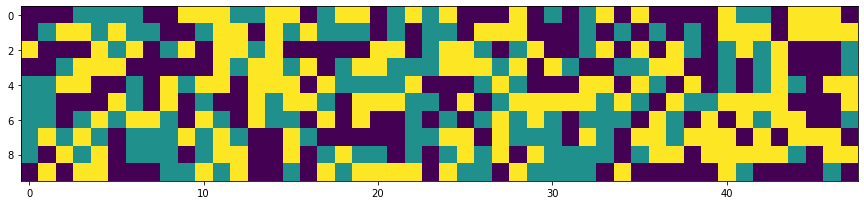

In [19]:
Q = experiment.Q
l_2 = []
for row in Q:
    l = []
    for column in row:
        max_action = np.argmax(column[2])
        l.append(max_action)
    l_2.append(np.array(l))
l = np.array(l_2)
#print(l)
fig, ax = plt.subplots(figsize=(15, 8))
im = ax.imshow(l)

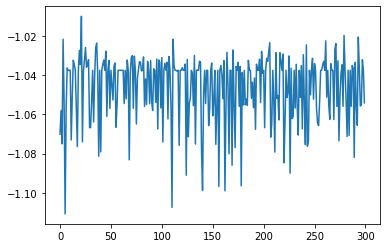

In [20]:
rewards = experiment.reward_list
plt.plot(rewards)

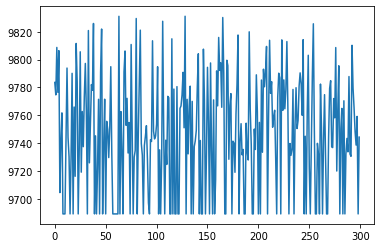

In [21]:
averages = experiment.average_list
plt.plot(averages)